In [298]:
# Imports and read the csv file of train data
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error as mse
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
df = pd.read_csv('BTC-USD(train).csv',parse_dates=True)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-11-10,362.265015,374.816010,357.561005,366.924011,366.924011,30450100
1,2014-11-11,365.856995,371.309998,363.734985,367.695007,367.695007,15838900
2,2014-11-12,367.984985,429.717987,367.984985,423.561005,423.561005,45783200
3,2014-11-13,427.273010,457.092987,401.122986,420.734985,420.734985,58945000
4,2014-11-14,418.416992,419.252014,384.789001,397.817993,397.817993,29589200


In [299]:
# Scale the data between 0 and 1 
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1,1))

In [300]:
# set the interval of train and prediction. train on first 1 values to predict the next day value
time_intervals_to_train = 1
prediction_interval = 1

x_train = []
y_train = [] 

In [301]:
# append them
for i in range(time_intervals_to_train,len(scaled_data)-prediction_interval):
    x_train.append(scaled_data[i-time_intervals_to_train:i,0])
    y_train.append(scaled_data[i+prediction_interval,0])

In [302]:
# convert them to an array from a list 
x_train = np.array(x_train)
y_train = np.array(y_train)

In [303]:
# make sure that the shape of x_train is 2 dimensional
x_train.shape

(2714, 1)

In [304]:
# reshape it to a 3 dimensional array for LSTM fitting
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [305]:
# our model
model = tf.keras.Sequential()
model.add(layers.LSTM(units=100, return_sequences=True,
 input_shape=(x_train.shape[1],1), dropout=0.1))
model.add(layers.LSTM(units=100, return_sequences=True,
 dropout=0.1))
model.add(layers.LSTM(units=100, dropout=0.1))
model.add(layers.Dense(units=1))
model.summary()
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 1, 100)            40800     
                                                                 
 lstm_31 (LSTM)              (None, 1, 100)            80400     
                                                                 
 lstm_32 (LSTM)              (None, 100)               80400     
                                                                 
 dense_10 (Dense)            (None, 1)                 101       
                                                                 
Total params: 201,701
Trainable params: 201,701
Non-trainable params: 0
_________________________________________________________________


In [306]:
# start the training 
model.fit(x_train,y_train,epochs=20,batch_size=128)

Epoch 1/100
22/22 [==============================] - 5s 7ms/step - loss: 0.0713
Epoch 2/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0352
Epoch 3/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0080
Epoch 4/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0101
Epoch 5/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0084
Epoch 6/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0078
Epoch 7/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0096
Epoch 8/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0095
Epoch 9/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0083
Epoch 10/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0102
Epoch 11/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0085
Epoch 12/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0073
Epoch 13/100
22/22 [=================

In [307]:
# test data read 
# Always a good practice to seperate the test data set and train data set 
df1 = pd.read_csv('BTC-USD(test).csv',parse_dates=True)
df1.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
299,2023-02-11,21651.841797,21891.410156,21618.449219,21870.875000,21870.875000,16356226232
300,2023-02-12,21870.902344,22060.994141,21682.828125,21788.203125,21788.203125,17821046406
301,2023-02-13,21787.000000,21898.414063,21460.087891,21808.101563,21808.101563,23918742607
302,2023-02-14,21801.822266,22293.140625,21632.394531,22220.804688,22220.804688,26792596581
303,2023-02-15,22220.585938,24307.841797,22082.769531,24307.841797,24307.841797,32483312909


In [308]:
# Get the actual test prices for plotting 
bitcoin_actual_prices = df1['Close'].values
bitcoin_actual_prices

array([40826.214844, 41502.75    , 41374.378906, 40527.363281,
       39740.320313, 39486.730469, 39469.292969, 40458.308594,
       38117.460938, 39241.121094, 39773.828125, 38609.824219,
       37714.875   , 38469.09375 , 38529.328125, 37750.453125,
       39698.371094, 36575.140625, 36040.921875, 35501.953125,
       34059.265625, 30296.953125, 31022.90625 , 28936.355469,
       29047.751953, 29283.103516, 30101.265625, 31305.113281,
       29862.917969, 30425.857422, 28720.271484, 30314.333984,
       29200.740234, 29432.226563, 30323.722656, 29098.910156,
       29655.585938, 29562.361328, 29267.224609, 28627.574219,
       28814.900391, 29445.957031, 31726.390625, 31792.310547,
       29799.080078, 30467.488281, 29704.390625, 29832.914063,
       29906.662109, 31370.671875, 31155.478516, 30214.355469,
       30111.998047, 29083.804688, 28360.810547, 26762.648438,
       22487.388672, 22206.792969, 22572.839844, 20381.650391,
       20471.482422, 19017.642578, 20553.271484, 20599.

In [309]:
# Take the values we will be predicting
test_inputs = df1['Close'].values
test_inputs = test_inputs.reshape(-1,1)
model_inputs = scaler.fit_transform(test_inputs)

In [310]:
model_inputs

array([[0.97369151],
       [1.        ],
       [0.99500802],
       [0.96207003],
       [0.93146421],
       [0.92160284],
       [0.92092474],
       [0.9593847 ],
       [0.86835591],
       [0.9120518 ],
       [0.93276723],
       [0.88750249],
       [0.85270051],
       [0.88202989],
       [0.88437223],
       [0.85408404],
       [0.92983293],
       [0.80837954],
       [0.78760532],
       [0.76664639],
       [0.71054445],
       [0.56423901],
       [0.59246922],
       [0.51132931],
       [0.51566119],
       [0.52481333],
       [0.55662929],
       [0.60344344],
       [0.54736064],
       [0.56925172],
       [0.50292643],
       [0.5649149 ],
       [0.52161046],
       [0.5306123 ],
       [0.56528   ],
       [0.51765059],
       [0.5392981 ],
       [0.53567286],
       [0.52419585],
       [0.4993217 ],
       [0.50660627],
       [0.53114623],
       [0.61982569],
       [0.62238913],
       [0.54487817],
       [0.57087063],
       [0.54119597],
       [0.546

In [311]:
# Same process as the train data. append the testing data that we will be predicting
x_test = []

for x in range(time_intervals_to_train,len(model_inputs)):
    x_test.append(model_inputs[x-time_intervals_to_train:x,0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [312]:
# make sure the shape is 3 dimensional
x_test.shape

(303, 1, 1)

In [313]:
# predict the values of x_test with the learnings made from training data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

10/10 [==============================] - 1s 2ms/step


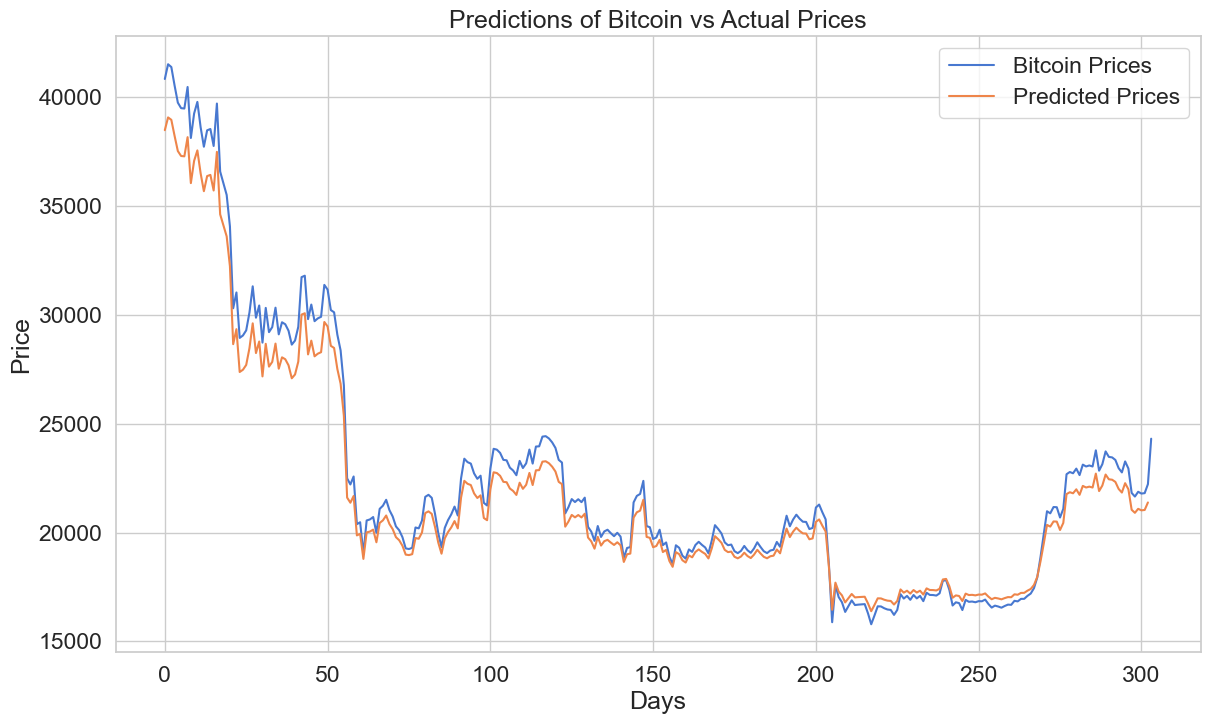

In [314]:
# Plot the actual prices against the predicted we just had 
plt.plot(bitcoin_actual_prices,label='Bitcoin Prices')
plt.plot(predictions,label='Predicted Prices')
plt.title('Predictions of Bitcoin vs Actual Prices')
plt.xlabel('Days')
plt.ylabel('Price USD')
plt.legend()
plt.show()

In [315]:
# check how well our predictions are.By percentage, we  are 3.13% wrong
mean_absolute_percentage_error = np.mean(np.abs(np.array(predictions)-np.array(test_inputs[:-1]))/np.abs(test_inputs[:-1]))
print('MAPE:' +str(mean_absolute_percentage_error*100))

MAPE:3.139145104132287


In [325]:
# We can see that on average we are wrong by 654 USD 
bitcoin_actual_prices.mean() - predictions.mean()

654.0621659736826